In [ ]:
"""
I had to pull my trapezoid integrator out of scipy so that it can be used more flexibely (on part of a series instead of just one value)
I also wanted to be able to compile this with numba
"""

In [1]:
import numpy as np
import h5py
import hdf5plugin

In [2]:
def tupleset(t, i, value):
    l = list(t)
    l[i] = value
    return tuple(l)


#adapted to work when the time series must be broken into partitions
def partitionTrapezoid(y, dx=1.0, axis=-1,lastVel=None,lastDisp=None):
    y = np.asarray(y)
    if(lastVel is not None): y=np.concatenate((np.array([lastVel]),y),axis=axis)
    d = dx
    nd = len(y.shape)
    #slice 1 and 2 just gets every other element
    slice1 = tupleset((slice(None),)*nd, axis, slice(1, None))
    slice2 = tupleset((slice(None),)*nd, axis, slice(None, -1))

    #now deal with the cumulative sume starting at the last point
    if(lastDisp is not None):
        #not really sure how this will play with multi dim data...
        res = d*(y[slice1] + y[slice2]) / 2.0
        res[0] = res[0]+lastDisp
        #now add the rest of the results to the cumsum
        res= np.cumsum(res,axis=axis)
    else:
        res = np.cumsum(d*(y[slice1] + y[slice2]) / 2.0, axis=axis)
    
    return res
"""
#test the partitioned integral
testX = np.arange(0,10,1)
testY = np.power(testX,2)
dx=1
integrateX = partitionTrapezoid(testY,dx=dx,axis=0)
#now integrate in steps

integrateXP1 = partitionTrapezoid(y=testY[0:5],dx=dx,axis=0)
lastDisp = integrateXP1[-1]
lastVel = testY[4]
integrateXP2 = partitionTrapezoid(y=testY[5:10],dx=dx,axis=0,lastVel=lastVel,lastDisp=lastDisp)
#integrateXP2 = cumTrapz(testY[5:10],dx=dx,axis=0,lastValue=None)
"""

In [12]:
data = h5py.File('1HzFullZFP_Compressed.hdf5','r')
dt = data['timestep'][:][0]
time = np.arange(0,(data['vel_0 ijk layout'].shape[0]-1)*dt,dt)

CPU times: user 19.8 s, sys: 4.21 s, total: 24.1 s
Wall time: 25.6 s


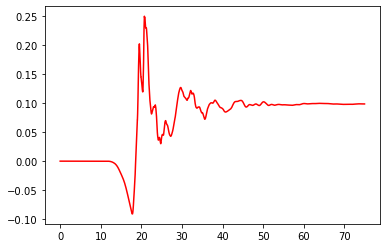

In [14]:
%%time
import matplotlib.pyplot as plt
point = (100,100,0)
wholeTimeSeries = data['vel_0 ijk layout'][:,point[0],point[1],point[2]]
#now integrate this time series and plot the result
y_int = partitionTrapezoid(y=wholeTimeSeries,dx=dt, axis=0)
plt.plot(time, y_int, 'r')


In [15]:
#this time integrate the time series in chunks

In [ ]:
%%time


result = np.zeros(shape=wholeTimeSeries.shape,dtype=wholeTimeSeries.dtype)
dtChunk = data['vel_0 ijk layout'].chunks[0]
# make sure that this is always one larger than it should be so that I can assign the first value to the last
#value from the previous trapezoid call
currentChunk = np.zeros(shape=(dtChunk),dtype=wholeTimeSeries.dtype)
lastVel = np.zeros(shape=(1),dtype=wholeTimeSeries.dtype)
lastDisp = np.zeros(shape=(1),dtype=wholeTimeSeries.dtype)

for i in range(0,data['vel_0 ijk layout'].shape[0],dtChunk):
    currentChunk = data['vel_0 ijk layout'][i:i+dtChunk,point[0],point[1],point[2]] #                  
    #integrate the current chunk, skip the first value since this was the last values
    #for the previous integrand
    currentChunk = partitionTrapezoid(y=currentChunk,dx=dt,axis=0,lastVel=lastVel,lastDisp=lastDisp)
    result[i:i+currentChunk.shape[0]] = currentChunk
    #save the last value so that the next integral starts in the correct position
    lastVel[:]  = data['vel_0 ijk layout'][i,point[0],point[1],point[2]]
    
#now plot as compared to the other result
plt.plot(time[0:result.shape[0]], y_int[0:result.shape[0]], 'r',time[0:result.shape[0]],result,'b')